In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes = True)

#get rid of future warnings with seaborn
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



#### Code

In [13]:
df[['ID','ZIP Code']] = df[['ID','ZIP Code']].astype('str')

#### Test

In [14]:

df[['ID', 'ZIP Code']].dtypes

ID          object
ZIP Code    object
dtype: object

# <br>

#### Define

Column "Experience" has some negative value

#### Code

In [15]:
#check the ammount of negative values
df[df['Experience'] < 0]['Experience'].value_counts()

-1    33
-2    15
-3     4
Name: Experience, dtype: int64

##### Lets find the quantitive variable with strong association with 'Experience'

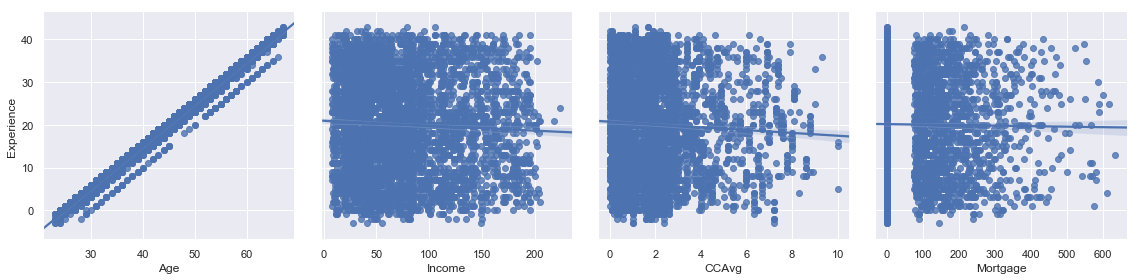

In [16]:
ncol = ['Age', 'Income','CCAvg', 'Mortgage']
grid = sns.PairGrid(df, y_vars = 'Experience', x_vars = ncol, height = 4)
grid.map(sns.regplot);

'Age' has a very strong association with 'Experience

Get the subset of 'Age' data with negative values in 'Experience

In [17]:
df[df['Experience'] < 0]['Age'].value_counts()

25    18
24    17
23    12
29     3
28     1
26     1
Name: Age, dtype: int64

**Observation:**

The subset of each age with negative values in 'Experience' is definitely small. 

**Decision:**
We can replace each negative 'Experience' value with the mean of positive 'Experience' value associated with the particular 'Age' value

<br>
Get a list of 'Age' values where we found some negative values in 'Experience'

In [18]:
ages = df[df['Experience'] < 0]['Age'].unique().tolist()
ages

[25, 24, 28, 23, 29, 26]

Get indexes of negative values in 'Experience'

In [19]:
indexes = df[df['Experience'] < 0].index.tolist()

Replace nagative 'Experience' values with the means

In [20]:
for i in indexes:
    for x in ages:
        df.loc[i,'Experience'] = df[(df.Age == x) & (df.Experience > 0)].Experience.mean()

#### Test

In [21]:
df[df['Experience'] < 0]['Age'].value_counts()

Series([], Name: Age, dtype: int64)

In [22]:
df.Experience.describe()

count    5000.000000
mean       20.135743
std        11.413140
min         0.000000
25%        10.000000
50%        20.000000
75%        30.000000
max        43.000000
Name: Experience, dtype: float64

In [23]:
df.to_csv('df.csv', index = False)

# <br>
All Data is clean and we can start Analysis
<br> 

# Analysis

### Questions

> - Is there some association between personal characteristics and the fact that person obtained Personal Loan (Loan Fact)? If so:
> - What are those Main Characteristics that has a higher association with Loan Fact and what the strength of correlation?
> - What the Segments of Main Characteristics, that has a higher strength of association with  Personal Loan?
> - What is the sample of Data with persons from Main Segments.

## Exploratory data analysis

###  Is there some association between personal characteristics and the fact that person obtained Personal Loan?

Let's check what the values or group of values of each variable lies inside group that have 'Personal Loan' and don't have that.

Since we found strong association between 'Age' and 'Experience' we decided to exclud 'Experience' from analysis steps to avoid multicollinearity.

#### QUANTATIVE VARIABLES

['Age', 'Income', 'CCAvg', 'Mortgage']

In [24]:
quant_df = df[['Personal Loan', 'Age', 'Income', 'CCAvg', 'Mortgage']].copy()

#### Correlation Table

In [25]:
quant_df.corr()

,Personal Loan,Age,Income,CCAvg,Mortgage
Personal Loan,1.000000,-0.007726,0.502462,0.366891,0.142095
Age,-0.007726,1.000000,-0.055269,-0.052030,-0.012539
Income,0.502462,-0.055269,1.000000,0.645993,0.206806
CCAvg,0.366891,-0.052030,0.645993,1.000000,0.109909
Mortgage,0.142095,-0.012539,0.206806,0.109909,1.000000


#### Heat map

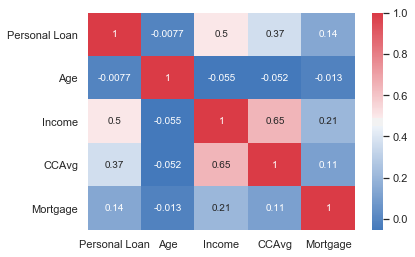

In [26]:
cmap = sns.diverging_palette(250, 10, as_cmap=True)
sns.heatmap(quant_df.corr(), cmap = cmap, annot = True);

In [27]:
# get association coefficients for 'Personal Loan' and exclude it's data from series
quant_df.corr()['Personal Loan'][1:]

Age        -0.007726
Income      0.502462
CCAvg       0.366891
Mortgage    0.142095
Name: Personal Loan, dtype: float64

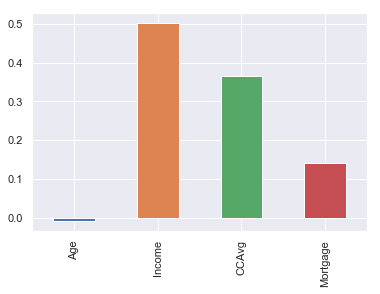

In [28]:
quant_df.corr()['Personal Loan'][1:].plot.bar();

**'Age'** and **'Mortgage'** both has very low cor.coef with Personal Loan. We may say that only **'Income'** and **'CCAvg**' has association with 'Personal Loan'

Let's check our confidense about this statment with logistic regression model:

In [29]:
import statsmodels.api as sm

In [30]:
quant_df['intercept'] = 1
log_mod = sm.Logit(quant_df['Personal Loan'], quant_df[['intercept', 'Age', 'Income', 'CCAvg', 'Mortgage']]).fit()

Optimization terminated successfully.
         Current function value: 0.200574
         Iterations 8


In [31]:
log_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Personal Loan   No. Observations:                 5000
Model:                          Logit   Df Residuals:                     4995
Method:                           MLE   Df Model:                            4
Date:                Mon, 01 Apr 2019   Pseudo R-squ.:                  0.3657
Time:                        15:12:21   Log-Likelihood:                -1002.9
converged:                       True   LL-Null:                       -1581.0
                                        LLR p-value:                4.743e-249
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -6.5144      0.308    -21.155      0.000      -7.118      -5.911
Age            0.0080      0.005      1.550      0.121      -0.002       0.018
Income         0.0351      0.002     22.313      0.000       0.032       0.038
CCAvg          0.0688      0.029      2.409      0.016       0.013       0.125
Mortgage       0.0007      0.000      1.757      0.079   -8.49e-05       0.002
==============================================================================
"""

#### The bar chart of P-Values distribution and threshold line 

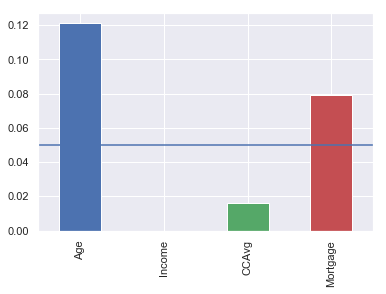

In [32]:
# exclude 'intercept'
log_mod.pvalues[1:5].plot.bar()
plt.axhline(y = 0.05);

**We can say with confidence** that 'Income' and 'CCAvg' both has statisticaly significant association with 'Personal Loan', since  their p-value in logistic regression < 0.05

#### The bar chart of coefficient distribution 

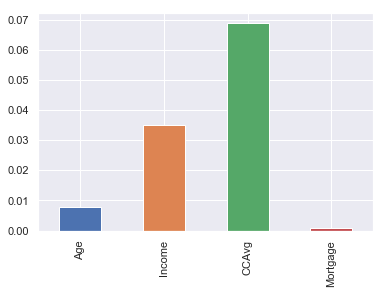

In [33]:
# exclude 'intercept'
log_mod.params[1:5].plot.bar();

**'CCAvg'** has strongest association with 'Personal Loan'

#### Filter columns with P-values less then 0.05 and store variables and it's coefficients into the dictionary

In [34]:
quant_df_main = {}
for i in log_mod.params[1:5].to_dict().keys():
    if log_mod.pvalues[i] < 0.05:
        quant_df_main[i] = log_mod.params[i]
    else:
        continue

In [35]:
quant_df_main

{'Income': 0.035086794726785976, 'CCAvg': 0.06879405526062024}

#### Compute the odds

In [36]:
quant_df_main_odds = {k : np.exp(v) for k, v in quant_df_main.items()}

In [37]:
quant_df_main_odds

{'Income': 1.0357095990302452, 'CCAvg': 1.0712155752174697}

### Conclusion:

'Personal Loan' has statisticaly significant association with:

> -  'Income' : coef = 0.03508
> -  'CCAvg' : coef = 0.06879

Both variables are positively associated with 'Personal Loan'. As soon as both have one unit as $1000 we may say the following:

> - **For each $1000 increase in 'Income'** we expect the odds to sell Personal Loan to increase by 3.57%, holding everything else constant

> - **For each $1000 increase in 'CCAvg'** we expect the odds to sell Personal Loan to increase by 7.12%, holding everything else constant

<br>

### CATEGORICAL VARIABLES

'ZIP Code', 'Family', 'Education'

'Family' and 'Education' are ordinal categorical variables so we may apply logistic regression direct to them. 'ZIP Code' is nominal, so we need to build dummy variables to check the association existence

In [38]:
cat_df = df[['ZIP Code', 'Family', 'Education', 'Personal Loan']].copy()

<br>

### 'Family' and  'Education'

In [39]:
cat_df.corr()

,Family,Education,Personal Loan
Family,1.000000,0.064929,0.061367
Education,0.064929,1.000000,0.136722
Personal Loan,0.061367,0.136722,1.000000


In [40]:
cat_df.corr()['Personal Loan'][0:2]

Family       0.061367
Education    0.136722
Name: Personal Loan, dtype: float64

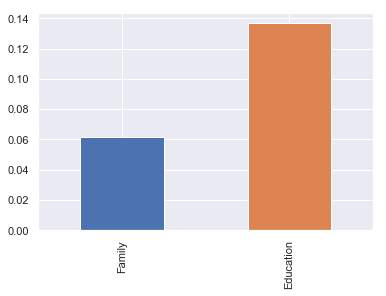

In [41]:
cat_df.corr()['Personal Loan'][0:2].plot.bar();

**'Family'** and **'Education'** has low association with 'Personal Loan'

Let's check our confidence with logistic regretion


In [42]:
cat_df['intercept'] = 1
log_mod = sm.Logit(cat_df['Personal Loan'], cat_df[['intercept', 'Family', 'Education']]).fit()

Optimization terminated successfully.
         Current function value: 0.305406
         Iterations 7


In [43]:
log_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Personal Loan   No. Observations:                 5000
Model:                          Logit   Df Residuals:                     4997
Method:                           MLE   Df Model:                            2
Date:                Mon, 01 Apr 2019   Pseudo R-squ.:                 0.03415
Time:                        15:12:22   Log-Likelihood:                -1527.0
converged:                       True   LL-Null:                       -1581.0
                                        LLR p-value:                 3.575e-24
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -3.7670      0.175    -21.574      0.000      -4.109      -3.425
Family         0.1623      0.042      3.863      0.000       0.080       0.245
Education      0.5487      0.059      9.260      0.000       0.433       0.665
==============================================================================
"""

**We can say with confidence** that 'Family' and 'Education' both has statisticaly significant association with 'Personal Loan', since  their p-value in logistic regression < 0.05

#### The bar chart of coefficient distribution 

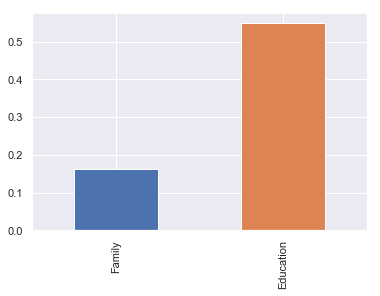

In [44]:
# exclude 'intercept'
log_mod.params[1:3].plot.bar();

**'Education'** has strongest association with 'Personal Loan'

#### Filter columns with P-values less then 0.05 and store variables and it's coefficients into the dictionary

In [45]:
cat_df_main = {}
for i in log_mod.params[1:3].to_dict().keys():
    if log_mod.pvalues[i] < 0.05:
        cat_df_main[i] = log_mod.params[i]
    else:
        continue

In [46]:
cat_df_main

{'Family': 0.1623178507480375, 'Education': 0.5487286631107698}

#### Compute the odds

In [47]:
cat_df_odds = {k : np.exp(v) for k, v in cat_df_main.items()}

In [48]:
cat_df_odds

{'Family': 1.1762340487826346, 'Education': 1.731050869500249}

### Conclusion:

'Personal Loan' has statisticaly significant association with:

> -  'Family' : coef = 0.16231
> -  'Education' : coef = 0.54873

Both variables are positively associated with 'Personal Loan'. We may say the following:

> - **For each unit increase in 'Family'** we expect the odds to sell Personal Loan to increase by 17.62%, holding everything else constant

> - **For each unit increase in 'Education'** we expect the odds to sell Personal Loan to increase by 73.11%, holding everything else constant

<br>

### 'ZIP Code'

In [49]:
cat_df.head()

,ZIP Code,Family,Education,Personal Loan,intercept
0,91107,4,1,0,1
1,90089,3,1,0,1
2,94720,1,1,0,1
3,94112,1,2,0,1
4,91330,4,2,0,1


In [50]:
zip_df = cat_df[['Personal Loan', 'intercept','ZIP Code']].copy()

In [51]:
zip_df.head(2)

,Personal Loan,intercept,ZIP Code
0,0,1,91107
1,0,1,90089


Lets check how we can group the 'Zip Code' values to minimize the number of dummies

In [52]:
zip_df['ZIP Code'].nunique()

467

In [53]:
zip_df['ZIP Code'].str[0:3].nunique()

57

In [54]:
zip_df['ZIP Code'].str[0:2].nunique()

7

In [55]:
zip_df['ZIP Code'].str[0:2].value_counts()

94    1472
92     988
95     815
90     703
91     565
93     417
96      40
Name: ZIP Code, dtype: int64

Guess this set is okay for the first view since we assume that the initial campaign of selling Personal Loans was evenly spreaded through all zip codes.

Let's get dummies...

In [56]:
dum_zip_df = zip_df.copy()

In [57]:
dum_zip_df['ZIP Code'] = dum_zip_df['ZIP Code'].str[0:2]

In [58]:
dum_zip_df.head(2)

,Personal Loan,intercept,ZIP Code
0,0,1,91
1,0,1,90


In [59]:
dum_zip_df = pd.get_dummies(dum_zip_df, prefix = "Z", drop_first = True)

In [60]:
dum_zip_df.head(2)

,Personal Loan,intercept,Z_91,Z_92,Z_93,Z_94,Z_95,Z_96
0,0,1,1,0,0,0,0,0
1,0,1,0,0,0,0,0,0


Fit a logic model

In [61]:
#exclude 'Personal Loan' from independ vars
dum_zip_df_columns = dum_zip_df.columns.drop('Personal Loan').tolist()

In [62]:
log_mod = sm.Logit(dum_zip_df['Personal Loan'], dum_zip_df[dum_zip_df_columns]).fit()

Optimization terminated successfully.
         Current function value: 0.316143
         Iterations 6


In [63]:
log_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Personal Loan   No. Observations:                 5000
Model:                          Logit   Df Residuals:                     4993
Method:                           MLE   Df Model:                            6
Date:                Mon, 01 Apr 2019   Pseudo R-squ.:               0.0001931
Time:                        15:12:24   Log-Likelihood:                -1580.7
converged:                       True   LL-Null:                       -1581.0
                                        LLR p-value:                    0.9962
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.2505      0.128    -17.521      0.000      -2.502      -1.999
Z_91           0.0234      0.191      0.122      0.903      -0.352       0.399
Z_92          -0.0019      0.168     -0.011      0.991      -0.331       0.328
Z_93           0.0875      0.206      0.425      0.671      -0.316       0.491
Z_94          -0.0182      0.157     -0.116      0.908      -0.325       0.289
Z_95           0.0327      0.174      0.187      0.851      -0.309       0.374
Z_96          -0.2618      0.614     -0.426      0.670      -1.465       0.941
==============================================================================
"""

**We can say with confidence** that any ZIP Code does not have statisticaly significant association with 'Personal Loan', since  their p-value in logistic regression > 0.05

# <br>

### BINARY VARIABLES

'Securities Account', 'CD Account', 'Online', 'Credit Card'

In [64]:
bin_df = df[['Personal Loan', 'Securities Account', 'CD Account', 'Online', 'CreditCard']].copy()

In [65]:
bin_df.head()

,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,0,1,0,0,0
1,0,1,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,1


In [66]:
bin_df.corr()['Personal Loan']

Personal Loan         1.000000
Securities Account    0.021954
CD Account            0.316355
Online                0.006278
CreditCard            0.002802
Name: Personal Loan, dtype: float64

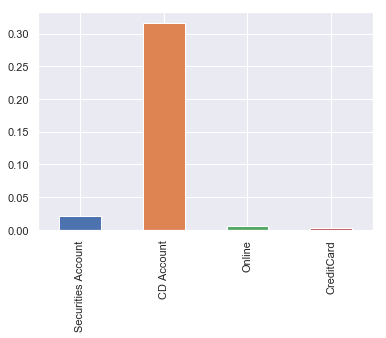

In [67]:
bin_df.corr()['Personal Loan'][1:].plot.bar();

**'CD Account'** - the only one variable with moderate association

<br>
Let's fit logistic regression

In [68]:
bin_df['intercept'] = 1
bin_df_colmn = bin_df.columns.drop('Personal Loan').tolist()
log_mod = sm.Logit(bin_df['Personal Loan'], bin_df[bin_df_colmn]).fit()

Optimization terminated successfully.
         Current function value: 0.273620
         Iterations 7


In [69]:
log_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Personal Loan   No. Observations:                 5000
Model:                          Logit   Df Residuals:                     4995
Method:                           MLE   Df Model:                            4
Date:                Mon, 01 Apr 2019   Pseudo R-squ.:                  0.1347
Time:                        15:12:25   Log-Likelihood:                -1368.1
converged:                       True   LL-Null:                       -1581.0
                                        LLR p-value:                 7.257e-91
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Securities Account    -1.3318      0.201     -6.621      0.000      -1.726      -0.938
CD Account             3.8738      0.206     18.780      0.000       3.470       4.278
Online                -0.5107      0.111     -4.598      0.000      -0.728      -0.293
CreditCard            -1.1518      0.153     -7.508      0.000      -1.452      -0.851
intercept             -1.9991      0.081    -24.581      0.000      -2.159      -1.840
======================================================================================
"""

In [70]:
log_mod = sm.Logit(bin_df['Personal Loan'], bin_df[['intercept', 'CD Account']]).fit()

Optimization terminated successfully.
         Current function value: 0.285748
         Iterations 6


In [71]:
log_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          Personal Loan   No. Observations:                 5000
Model:                          Logit   Df Residuals:                     4998
Method:                           MLE   Df Model:                            1
Date:                Mon, 01 Apr 2019   Pseudo R-squ.:                 0.09632
Time:                        15:12:25   Log-Likelihood:                -1428.7
converged:                       True   LL-Null:                       -1581.0
                                        LLR p-value:                 3.340e-68
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.5508      0.056    -45.301      0.000      -2.661      -2.440
CD Account     2.4049      0.128     18.730      0.000       2.153       2.657
==============================================================================
"""

In [72]:
bin_odds = {'CD Account' : np.exp(log_mod.params[1])}

In [73]:
bin_odds

{'CD Account': 11.076978939724048}

### Conclusion:

'Personal Loan' has statisticaly significant **positive** association with only:

> -  'CD Account' : coef = 2.40

We may say the following:

> - **With customer been hold CD Account with The Bank** we expect the odds to sell Personal Loan to increase 10 times, holding everything else constant

<br><br>

## Summary Conclusion:

'Personal Loan' has statisticaly significant association with:

> -  'CD Account' : coef = 2.40 : odds = 11.07
> -  'Family' : coef = 0.16231 : odds = 1.176
> -  'Education' : coef = 0.54873 : odds = 1.731
> -  'Income' : coef = 0.03508 : odds = 1.036
> -  'CCAvg' : coef = 0.06879 : odds = 1.071

Both variables are positively associated with 'Personal Loan'. We may say the following:

> - **With customer been hold CD Account with The Bank** we expect the odds to sell Personal Loan to increase **11 times**, holding everything else constant

> - **For each unit increase in 'Family'** we expect the odds to sell Personal Loan to increase **by 17.62%**, holding everything else constant

> - **For each unit increase in 'Education'** we expect the odds to sell Personal Loan to increase **by 73.11%**, holding everything else constant

> - **For each $1000 increase in 'Income'** we expect the odds to sell Personal Loan to increase **by 3.57%**, holding everything else constant

> - **For each $1000 increase in 'CCAvg'** we expect the odds to sell Personal Loan to increase **by 7.12%**, holding everything else constant

As soon as we found that the 'Personal Loan' depends on FIVE main characteristics, let's subset our data frame and get a closer look at the data.

# <br>

#  Explanatory analysis

>>> ### What are those Main Characteristics that has a higher association  with Loan Fact and what the strength of association ?

Here is a subset of the initial data frame with just characteristics that have a positive association  with 'Personal Loan' and the size of association  is higher than moderate

In [74]:
df = pd.read_csv ('df.csv')

In [75]:
df.head(1)

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Securities Account,CD Account,Online,CreditCard,Personal Loan
0,1,25,1.0,49,91107,4,1.6,1,0,1,0,0,0,0


In [76]:
exp_df = df[['Income', 'CCAvg', 'Family', 'Education', 'CD Account', 'Personal Loan']].copy()

In [77]:
exp_df.head(2)

,Income,CCAvg,Family,Education,CD Account,Personal Loan
0,49,1.6,4,1,0,0
1,34,1.5,3,1,0,0


Let's apply logistic regression on this subset

In [78]:
exp_df['intercept'] = 1

In [79]:
log_mod = sm.Logit(exp_df['Personal Loan'], exp_df[['intercept','Income', 'CCAvg', 'Family', 'Education', 'CD Account']]).fit()

Optimization terminated successfully.
         Current function value: 0.134028
         Iterations 9


##### Get P-Values for each variable

In [80]:
log_mod.pvalues[1:]

Income        1.568180e-104
CCAvg          4.872101e-03
Family         2.077119e-21
Education      2.509902e-53
CD Account     1.430875e-28
dtype: float64

All p-values are less than 0.05
<br><br>

##### Get Odds for each variable

In [81]:
odds = np.exp(log_mod.params)

In [82]:
odds

intercept      0.000001
Income         1.056149
CCAvg          1.114028
Family         1.991695
Education      5.352795
CD Account    12.021627
dtype: float64

In [83]:
odds_df = pd.DataFrame(odds[1:], columns = ["Odds"])

In [84]:
odds_df['odds_increment'] = odds_df.Odds

<br><br>
##### Here is the data frame with Main Characteristics ...
... and their odds to increase the chance to sell Personal Loan with increase value of variable by one unit

In [85]:
odds_df.sort_values('Odds', ascending = False)

,Odds,odds_increment
CD Account,12.021627,12.021627
Education,5.352795,5.352795
Family,1.991695,1.991695
CCAvg,1.114028,1.114028
Income,1.056149,1.056149


##### The chart demonstrating the proportion  of strength of association  between Personal Loan and values of Main Characteristics

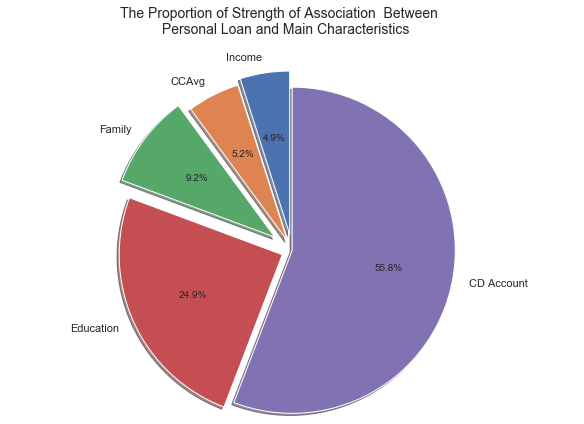

In [159]:
sizes = odds_df.Odds.tolist()# list of sizes of slices
labels = odds_df.index.tolist() # list of labels 
explode = (0.15, 0.1, 0.2, 0.1, 0)  # "explode" the 2nd and 3rd slices  
fig = plt.figure(figsize=(10, 5))
plt.suptitle('The Proportion of Strength of Association  Between  \n Personal Loan and Main Characteristics', \
          fontsize = 14, y = 1.18)
plt.axis('equal'); # set aspect ration as equal to make sure the pie is drawn as a circle
plt.pie(sizes, labels = labels, explode = explode, radius = 1.5, \
        shadow = True, startangle = 90,autopct= '%1.1f%%')

plt.savefig('proportion_of_stregth_of_association.png', bbox_inches = 'tight');

<br><br>

>>> ##  What the Segments of Main Characteristics, that has a higher strength of association with  Personal Loan?

Lets get a closer look at each of Main Characteristics

### CD Account

##### Here is the distribution of "Personal Loan"  values among groups of "CD Account"  values

In [87]:
series_cd = exp_df[exp_df['Personal Loan'] == 1]['CD Account'].value_counts()
series_cd

0    340
1    140
Name: CD Account, dtype: int64

In [88]:
series_cdd = exp_df[exp_df['Personal Loan'] == 0]['CD Account'].value_counts()
series_cdd

0    4358
1     162
Name: CD Account, dtype: int64

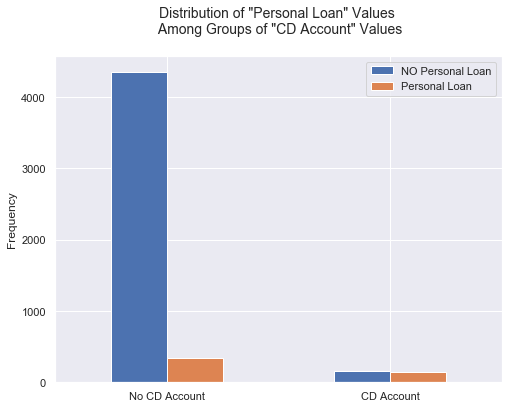

In [160]:
pd.DataFrame(dict( NO_PL= series_cdd, PL= series_cd,)).plot.bar(figsize = (8,6))
plt.ylabel('Frequency')
plt.xticks(np.arange(2),('No CD Account','CD Account'), rotation = 'horizontal')
plt.legend(('NO Personal Loan', 'Personal Loan'));
plt.title('Distribution of "Personal Loan" Values \n Among Groups of "CD Account" Values', fontsize = 14, y = 1.05);
plt.savefig('distribution_of_PL_among_CDacc.png', bbox_inches = 'tight')

We may say that **the proportion** of persons who has Personal Loan among them who has CD account with The Bank **is quit high**.<br>
Let's see the exact number of proportion of "loanees" among "depositees"

In [90]:
series = exp_df[exp_df['CD Account'] == 1]['Personal Loan'].value_counts()

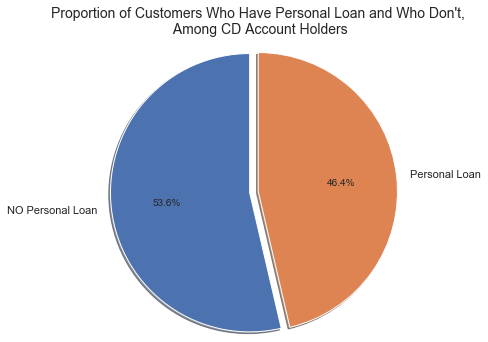

In [185]:
plt.axis('equal')
plt.title('Proportion of Customers Who Have Personal Loan and Who Don\'t,\n Among CD Account Holders', \
          fontsize = 14, y = 1.2)
labels = ['NO Personal Loan','Personal Loan']
plt.pie(series, labels = labels,autopct= '%1.1f%%', shadow = True,explode = (0.1, 0), radius = 1.6, startangle = 90)
plt.savefig('Proportion_of_loanees_among_depositees.png', bbox_inches = 'tight');

**Conclusion**

> - 46.4% of CD Account Holders have Perconal Loan. 
> - For 'CD Account' characteristic - the main segment to sell Personal Loan is the people who already have a CD Account with the Bank.
> - Target value of 'CD Account' variable = 1

<br>

### Education

##### Here is the distribution of "Personal Loan" values among groups of  "Education" values 

In [92]:
series_ed = exp_df[exp_df['Personal Loan'] == 1]['Education'].value_counts()
series_ed

3    205
2    182
1     93
Name: Education, dtype: int64

In [93]:
series_edd = exp_df[exp_df['Personal Loan'] == 0]['Education'].value_counts()
series_edd

1    2003
3    1296
2    1221
Name: Education, dtype: int64

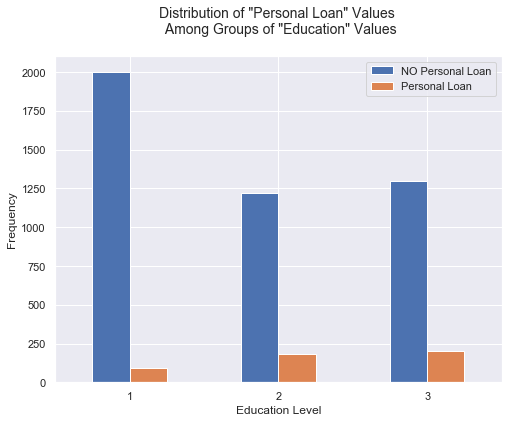

In [162]:
pd.DataFrame(dict(NO_PL= series_edd, PL= series_ed)).plot.bar(figsize = (8,6))
plt.ylabel('Frequency')
plt.xlabel('Education Level')
plt.xticks(np.arange(3),('1','2','3'), rotation = 'horizontal')
plt.legend(('NO Personal Loan', 'Personal Loan'))
plt.title('Distribution of "Personal Loan" Values \n Among Groups of "Education" Values', fontsize = 14, y = 1.05);
plt.savefig('distribution_PL_among_Education.png', bbox_inches = 'tight')

We may say that **the proportion** of persons who has Personal Loan among them who has Third and Second Level of Education **is higher** than proportion among people who has First level of Edication.

<br>
Let's see the exact numbers of proportions.

In [95]:
series_edu_3 = exp_df[exp_df['Education'] == 3]['Personal Loan'].value_counts()

In [96]:
series_edu_2 = exp_df[exp_df['Education'] == 2]['Personal Loan'].value_counts()

In [97]:
series_edu_1 = exp_df[exp_df['Education'] == 1]['Personal Loan'].value_counts()

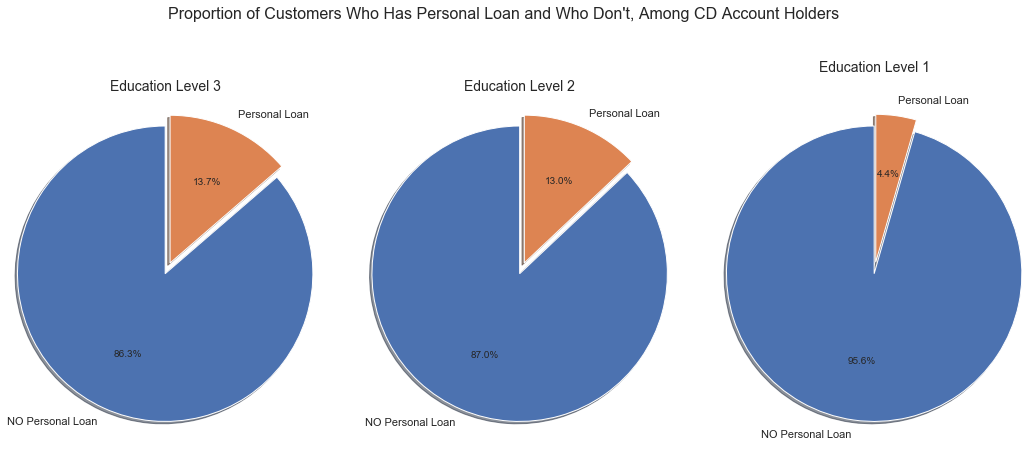

In [183]:
labels = ['NO Personal Loan','Personal Loan']
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (18,6),subplot_kw=dict(aspect="equal"))
plt.axis('equal')
ax1.pie(series_edu_3, labels = labels, autopct= '%1.1f%%', shadow = True,explode = (0, 0.1), radius = 1.25, startangle = 90)
ax1.set_title('Education Level 3',fontsize = 14, y = 1.1)

ax2.pie(series_edu_2, labels = labels, autopct= '%1.1f%%', shadow = True,explode = (0, 0.1), radius = 1.25, startangle = 90)
ax2.set_title('Education Level 2', fontsize = 14, y = 1.1)

ax3.pie(series_edu_1, labels = labels, autopct= '%1.1f%%', shadow = True,explode = (0, 0.1), radius = 1.25, startangle = 90);
ax3.set_title('Education Level 1',fontsize = 14, y = 1.1)

plt.suptitle('Proportion of Customers Who Has Personal Loan and Who Don\'t, Among CD Account Holders', \
             fontsize = 16, y = 1.12);

plt.savefig('Proportion_of_PL_among edu_levels.png', bbox_inches = 'tight');

In [99]:
series_edu_4 = exp_df[exp_df['Personal Loan'] == 1]['Education'].value_counts()
series_edu_4

3    205
2    182
1     93
Name: Education, dtype: int64

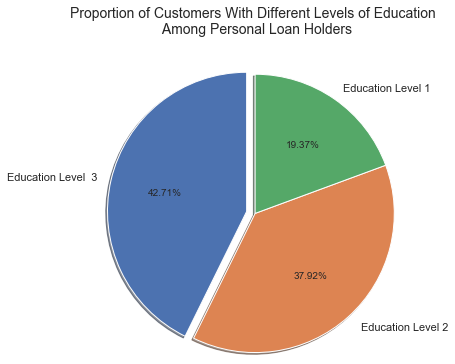

In [181]:
plt.axis('equal')
plt.title('Proportion of Customers With Different Levels of Education \n Among Personal Loan Holders', \
          fontsize = 14, y = 1.3)
labels = ['Education Level  3',' Education Level 2','Education Level 1']
plt.pie(series_edu_4, labels = labels, autopct= '%1.2f%%', shadow = True,explode = (0.1, 0, 0), radius = 1.6, startangle = 90);
plt.savefig('Proportion_edu_levels_among_PL.png', bbox_inches = 'tight');

**Conclusion**

> - 42.7%  and 37.9% of persons who have Personal Loan, have Education level 3 and Level 2 respectively. 
> - For 'Education' characteristic - the main segments to sell Personal Loan is the people who have Second and Third levels of education
> - Target values of 'Education' variable are 3 and 2 in descending order of priority

# <br>

## Family

##### Here is the distribution of "Personal Loan"  values among groups of "Family"  values

In [101]:
series_fam = exp_df[exp_df['Personal Loan'] == 1]['Family'].value_counts()
series_fam

4    134
3    133
1    107
2    106
Name: Family, dtype: int64

In [102]:
series_famm = exp_df[exp_df['Personal Loan'] == 0]['Family'].value_counts()
series_famm

1    1365
2    1190
4    1088
3     877
Name: Family, dtype: int64

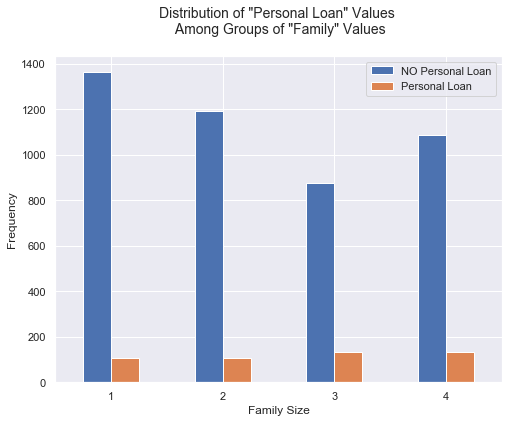

In [172]:
pd.DataFrame(dict( NO_PL = series_famm, PL= series_fam,)).plot.bar(figsize = (8,6))
plt.ylabel('Frequency')
plt.xlabel('Family Size')
plt.xticks(np.arange(4),('1', '2', '3', '4'), rotation = 'horizontal')
plt.legend(('NO Personal Loan', 'Personal Loan'));
plt.title('Distribution of "Personal Loan" Values \n Among Groups of "Family" Values', fontsize = 14, y = 1.05);
plt.savefig('distribution_of_PL_among_family.png', bbox_inches = 'tight')

**We may say** that the proportion of persons who has Personal Loan among them who has Family size 2 and 3 is highest proportion.
Let's see the exact number of that proportions of "loanees" among "depositees"

In [104]:
series_fam_3 = exp_df[exp_df['Family'] == 3]['Personal Loan'].value_counts()

In [105]:
series_fam_4 = exp_df[exp_df['Family'] == 4]['Personal Loan'].value_counts()

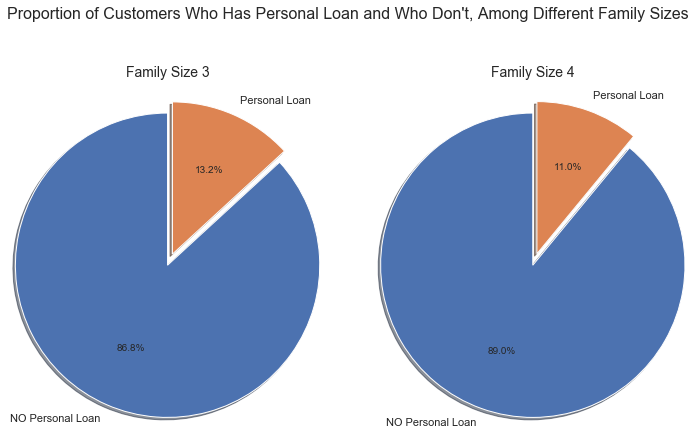

In [180]:
labels = ['NO Personal Loan','Personal Loan']

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,6),subplot_kw=dict(aspect="equal"))
fig.suptitle('Proportion of Customers Who Has Personal Loan and Who Don\'t, \
Among Different Family Sizes', fontsize = 16, y = 1.1, x = 0.51);

ax1.pie(series_fam_3, labels = labels, autopct= '%1.1f%%', shadow = True,explode = (0, 0.1), radius = 1.25, startangle = 90)
ax1.set_title('Family Size 3',fontsize = 14, y = 1.1)

ax2.pie(series_fam_4, labels = labels, autopct= '%1.1f%%', shadow = True,explode = (0, 0.1), radius = 1.25, startangle = 90)
ax2.set_title('Family Size 4', fontsize = 14, y = 1.1);

plt.savefig('Proportion_of_PL_among_family_levels.png', bbox_inches = 'tight');

In [107]:
series_fam

4    134
3    133
1    107
2    106
Name: Family, dtype: int64

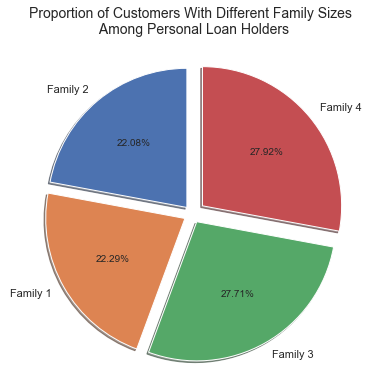

In [179]:
plt.axis('equal')
plt.title('Proportion of Customers With Different Family Sizes \n Among Personal Loan Holders', \
          fontsize = 14, y = 1.3)
labels = ['Family 2',' Family 1','Family 3','Family 4']
plt.pie(series_fam.sort_values(ascending = True), labels = labels, \
        autopct= '%1.2f%%', shadow = True, explode = (0.1, 0.1, 0.1,0.15), radius = 1.6, startangle = 90);
plt.savefig('Proportion_family_size_among_PL.png', bbox_inches = 'tight');

**Conclusion**

> - 27.9%  and 27.7% of persons who have Personal Loan, have Family size 4 and Level 3 respectively. 
> - For 'Family' characteristic - the main segments to sell Personal Loan is the people who have Family Size 3 and 4.
> - Target values of 'Family' variable are 3 and 4 in descending order of priority, since the proportion of people who has Personal Loan is the higthest with Family Size 3 - 13,2%.

# <br>

## CCAvg

Here is the distribution of "CCAvg" values among Personal Loan holders and among whole population.

In [109]:
series_cca = exp_df[exp_df['Personal Loan'] == 1]['CCAvg'].value_counts()

In [110]:
series_cca.describe()

count    95.000000
mean      5.052632
std       3.349717
min       1.000000
25%       2.000000
50%       5.000000
75%       7.000000
max      19.000000
Name: CCAvg, dtype: float64

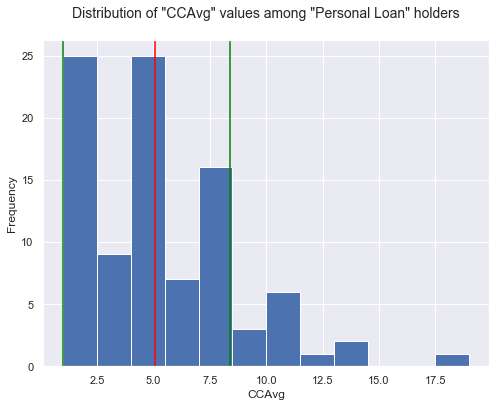

In [175]:
width = 1.5 #wdth of bins in histogram - play with it to find good point for groupping
series_cca.plot.hist(bins = np.arange(series_cca.min(), series_cca.max() + width, width ), figsize = (8,6))
plt.xlabel('CCAvg')
plt.axvline(x = series_cca.mean(), color = 'red')
plt.axvline(x = series_cca.min(), color = 'green')
plt.axvline(x = series_cca.mean() + series_cca.std(), color = 'green')
plt.title('Distribution of "CCAvg" values among "Personal Loan" holders', fontsize = 14, y = 1.05);
plt.savefig('Distrib_ccavg_among_PL.png', bbox_inches = 'tight')

**We may say** that CCAvg characteristics values can be devided in three groups in descending order of priority consider its frequncy among Personal Loan holder:


> - Group I:  1 < CCAvg < 2.5
> - Group II:  4 < CCAvg < 5.5
> - Group III:  7 < CCAvg < 8.5

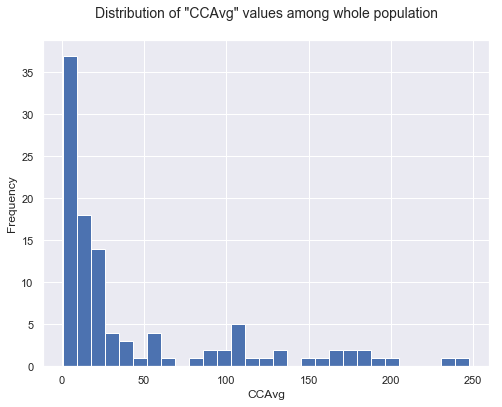

In [176]:
series_ccaa = exp_df['CCAvg'].value_counts()
width = 8.5 #wdth of bins in histogram - play with it to find good point for groupping
series_ccaa.plot.hist(bins = np.arange(series_ccaa.min(), series_ccaa.max() + width, width ), figsize = (8,6))
plt.xlabel('CCAvg')
plt.title('Distribution of "CCAvg" values among whole population', fontsize = 14, y = 1.05);
plt.savefig('Distrib_ccavg_among_population.png', bbox_inches = 'tight')

**We may say**, that all our groups of 'CCAvg' defined as priority groups to sell Personal Loan, lies inside segment with pretty high frequency among whole population. 

<br><br>
**Conclusion**

> **Target groups of 'CCAvg' characteristic is in descending order of priority:**
 
> - Group I:  1 < CCAvg < 2.5
> - Group II:  4 < CCAvg < 5.5
> - Group III:  7 < CCAvg < 8.5

# <br>

### Income

Here is the distribution of "Income" values among Personal Loan holders and among whole population.

In [113]:
series_inc = exp_df[exp_df['Personal Loan'] == 1]['Income'].value_counts()

In [114]:
series_inc.describe()

count    102.000000
mean       4.705882
std        2.723525
min        1.000000
25%        2.000000
50%        4.000000
75%        7.000000
max       11.000000
Name: Income, dtype: float64

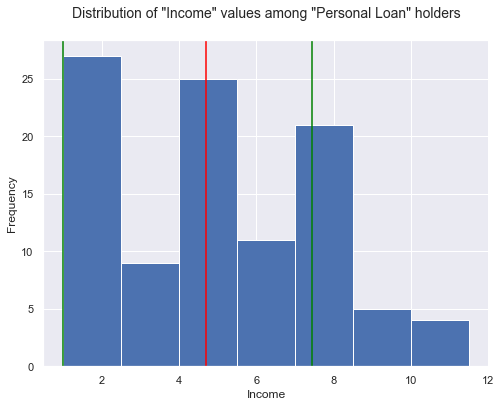

In [177]:
width = 1.5 #wdth of bins in histogram - play with it to find good point for groupping
series_inc.plot.hist(bins = np.arange(series_inc.min(), series_inc.max() + width, width ), figsize = (8,6))
plt.xlabel('Income')
plt.axvline(x = series_inc.mean(), color = 'red')
plt.axvline(x = series_inc.min(), color = 'green')
plt.axvline(x = series_inc.mean() + series_inc.std(), color = 'green')
plt.title('Distribution of "Income" values among "Personal Loan" holders', fontsize = 14, y = 1.05);
plt.savefig('Distrib_income_among_PL.png', bbox_inches = 'tight')

**We may say** that 'Income' characteristic values can be devided in three groups in descending order of priority consider its frequncy among Personal Loan holder:


> - Group I:  1 < Income < 2.5
> - Group II:  4 < Income < 5.5
> - Group III:  7 < Income < 8.5

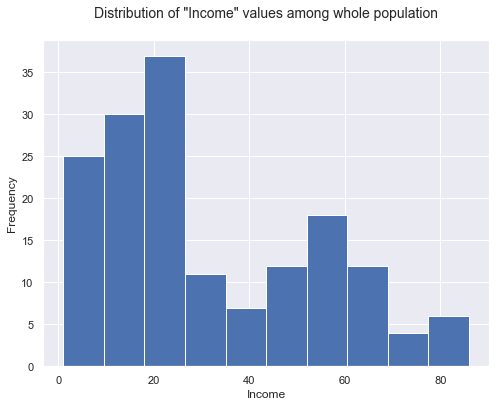

In [178]:
series_incc = exp_df['Income'].value_counts()
width = 8.5 #wdth of bins in histogram - play with it to find good point for groupping
series_incc.plot.hist(bins = np.arange(series_incc.min(), series_incc.max() + width, width ), figsize = (8,6))
plt.xlabel('Income')
plt.title('Distribution of "Income" values among whole population', fontsize = 14, y = 1.05);
plt.savefig('Distrib_income_among_population.png', bbox_inches = 'tight')

**We may say**, that all our groups of 'Income' defined as priority groups to sell Personal Loan, lies inside segment with pretty high frequency among whole population. 

<br><br>
**Conclusion**

> **Target groups of 'Income' characteristic is:**

> - Group I:  1 < Income < 2.5
> - Group II:  4 < Income < 5.5
> - Group III:  7 < Income < 8.5

# <br> 

>>> ## What is the sample of Data with persons from Main Segments.

As we found above, there are some segments of main characteristics with higher strength of association with Personal Loan.

Let's look at the samples of the database with those segments...

Here, in one place, are those characteristics segments we found earlier.
Have a look one more time:

### CD Account
> - 46.4% of CD Account Holders have Perconal Loan. 
> - For 'CD Account' characteristic - the main segment to sell Personal Loan is the people who already have a CD Account with the Bank.
> - **Target value of 'CD Account' variable:**
>> - **1**
<br>
### Education
> - 42.7%  and 37.9% of persons who have Personal Loan, have Education level 3 and Level 2 respectively. 
> - For 'Education' characteristic - the main segments to sell Personal Loan is the people who have Second and Third levels of education
> - **Target values of 'Education' variable in descending order of priority:**
>> - **3**
>> - **2**
<br>
### Family
> - 27.9%  and 27.7% of persons who have Personal Loan, have Family size 4 and Level 3 respectively. 
> - For 'Family' characteristic - the main segments to sell Personal Loan is the people who have Family Size 3 and 4.
> - **Target values of 'Family' variable in descending order of priority**, since the proportion of people who has Personal Loan is the higthest with Family Size 3 - 13,2%.
>> - **3**
>> - **4**
<br>
### CCAvg
> **Target groups of 'CCAvg' characteristic is in descending order of priority:**
 <br>(in thousands usd)
> - Group I:  1 < CCAvg < 2.5
> - Group II:  4 < CCAvg < 5.5
> - Group III:  7 < CCAvg < 8.5
<br><br>
### Income
> **Target groups of 'Income' characteristic is:**
<br>(in thousands usd)
> - Group I:  1 < Income < 2.5
> - Group II:  4 < Income < 5.5
> - Group III:  7 < Income < 8.5

Now we may build subsets of customers step by step with the idea in mind that:
<br>**the more segments we take into account, the higher probability to sell the product among this customers** 

Here is the subset with the highest association with Personal Loan, that is, as we remember, mean the highest probability to sell the product.

CD Account = 1<br>
Education = 3<br>
Family = 3<br>
1 < CCAvg < 2.5<br>
1 < Income < 2.5<br>

In [117]:
df[(df['Personal Loan'] == 0) &\
   (df['CD Account'] == 1) &\
   (df['Education'] == 3) &\
   (df['Family'] == 3) &\
   (df['CCAvg'] > 1) &\
   (df['CCAvg'] < 2.5) &\
   (df['Income'] > 1) &\
   (df['Income'] < 2.5)]

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Securities Account,CD Account,Online,CreditCard,Personal Loan


<br><br>
**We may say** that this ideal combination of characteristics does not exist among customers in our database.<br><br>
Lets do step-by-step.

In [118]:
CD = df[(df['Personal Loan'] == 0) & (df['CD Account'] == 1)]
CD.shape[0]

162

In [119]:
CD_EDU_3 = df[(df['Personal Loan'] == 0) & (df['CD Account'] == 1)&(df['Education'] == 3)]
CD_EDU_3.shape[0]

43

In [120]:
CD_EDU_3_FM_3 = df[(df['Personal Loan'] == 0) & (df['CD Account'] == 1)&(df['Education'] == 3)&(df['Family'] == 3)]
CD_EDU_3_FM_3.shape[0]

11

In [121]:
CD_EDU_3_FM_4 = df[(df['Personal Loan'] == 0) & (df['CD Account'] == 1)&(df['Education'] == 3)&(df['Family'] == 4)]
CD_EDU_3_FM_4.shape[0]

9

In [122]:
CD_EDU_3_FM_12 = df[(df['Personal Loan'] == 0) & (df['CD Account'] == 1)&(df['Education'] == 3)&(df['Family'] < 3)]
CD_EDU_3_FM_12.shape[0]

23

<br><br>
**Here is the list customer's ID in descending order of probability to sell the product:**
<br> Letter "A" is a label of higher priority and associated with value "1" in 'CD Account'

In [123]:
A_ID = CD_EDU_3_FM_3.ID.tolist()
len(A_ID)

11

In [124]:
A_ID.extend(CD_EDU_3_FM_4.ID.tolist())
len(A_ID)

20

In [125]:
A_ID.extend(CD_EDU_3_FM_12.ID.tolist())
len(A_ID)

43

In [126]:
#check
len(A_ID) == CD_EDU_3.shape[0]

True

**"A_ID" is the list of customers ID** who has higher probability to bought the product.<br>
Total 43 customers.<br><br>
Use this list to subset data from dataset with customers contacts.

In case we need next subset with data of customers who has higher probability to bought the product - we may use the same approach.<br><br>

This is subset of data with customers who has lower probability to bought the product than customers from first subset, but higher probability  among rest population

In [127]:
NOCD_EDU_3_FM_3_CCA_1 = df[(df['Personal Loan'] == 0) &\
   (df['CD Account'] == 0) &\
   (df['Education'] == 3) &\
   (df['Family'] == 3)&\
   (df['CCAvg'] > 1)&\
   (df['CCAvg'] < 2.5)]

In [128]:
NOCD_EDU_3_FM_3_CCA_1.head(3)

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Securities Account,CD Account,Online,CreditCard,Personal Loan
21,22,57,27.0,63,90095,3,2.0,3,0,0,0,1,0,0
40,41,57,32.0,84,92672,3,1.6,3,0,1,0,0,0,0
297,298,55,25.0,70,93720,3,1.4,3,0,0,0,1,0,0


**B_ID - the list of customers ID** to subset from dataset with customers contacts.

In [129]:
B_ID = NOCD_EDU_3_FM_3_CCA_1.ID.tolist()
len(B_ID)

81

# <br>

## Summary Conclusion

We made the simple step-by-step analysis of customer's characteristics to identify patterns to effectively choose the subset of customers who have a higher probability to buy new product "Personal Loan" from The Bank. We performed the following steps:
> - We check all twelve characteristics whether or not each of them has an association with the fact the product been sold.
> - We find FIVE main characteristics that have higher than moderate strength of association with the product.
> - We analyze main characteristics and get segments in each with different strength of association with the product.
> - We tried to make a subset of customers with ideal characteristics who has the highest probability to buy the product. Unfortunately, our dataset does not contain such information. So...
> - We build a simple algorithm to make a subset of data to get the customers IDs who have a high probability to buy the product.